# Emulate MIMO controller with LSTM
With the trained model saved from 02Train_MIMO.ipynb, run the TCLab with the set point data. The LSTM model will emulate the behavior it learned from the controller and predict the heater output to achieve the given setpoint.

Of particular significance is the fact that the LSTM is able to predict the behavior of the controller every second, whereas the original controller took 3 seconds for each new heater output. The data is formatted such that it still only takes every 3 seconds of data for the past 15 seconds as input, but it can constantly update this every second (or faster if desired). This shows a distinct advantage of using the LSTM to emulate controller behavior as the controller becomes more computationally complex. 

Features:
* Creates a movie of the images if make_mp4 = True
* Uses the set point profile stored in 30min_SP_data.csv file for consistency
  * This is 30 minutes of set point data
* Saves final plots as .eps files

In [ ]:
import tclab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time
from tqdm import tqdm # Progress bar
import pickle
from gekko import GEKKO

# For LSTM model
from keras.models import load_model

In [ ]:
# Make an MP4 animation?
make_mp4 = True
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

In [ ]:
# Connect to Arduino
a = tclab.TCLab()
# Find current T1, T2
print('Temperature 1: {0:0.2f} °C'.format(a.T1))
print('Temperature 2: {0:0.2f} °C'.format(a.T2))

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 27.34 °C
Temperature 2: 28.31 °C


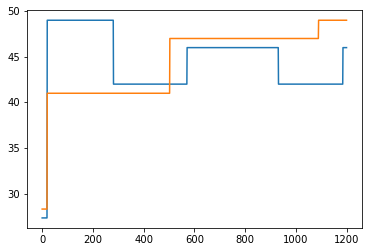

In [ ]:
# Run time in minutes
run_time = 60.0
window = 20

# Number of cycles
loops = int(20.0*run_time)
tm = np.zeros(loops)

# Temperature and heater data arrays
T1 = np.ones(loops) * a.T1 
Tsp1 = np.ones(loops) * a.T1 
T2 = np.ones(loops) * a.T2 
Tsp2 = np.ones(loops) * a.T2 
Q1_mpc = np.zeros(loops)
Q2_mpc = np.zeros(loops)

Q1_lstm = np.zeros(loops)
Q2_lstm = np.zeros(loops)

# Heater set point steps
end = window # leave 1st window seconds of Q1s as T.ambient
while end <= loops:
    start = end
    end += random.randint(200,600) # keep new Q1s value for anywhere from 5 to 10 minutes
    Tsp1[start:end] = random.randint(40,50)
    
end = window # leave 1st window seconds of Q1s as T.ambient
while end <= loops:
    start = end
    end += random.randint(200,600) # keep new Q1s value for anywhere from 5 to 10 minutes
    Tsp2[start:end] = random.randint(40,50)

plt.plot(Tsp1)
plt.plot(Tsp2)
# plt.ylim([0,100]);

In [ ]:
# gekko_dict = pickle.load(open('mpc_240.pkl', 'rb'))
# mpc_m = gekko_dict['model']
# TC1 = gekko_dict['TC1']
# TC2 = gekko_dict['TC2']
# Q1 = gekko_dict['Q1']
# Q2 = gekko_dict['Q2']

#########################################################
# Initialize Model
#########################################################
m = GEKKO(name='tclab-mpc',remote=True)

# 60 second time horizon, steps of 3 sec
m.time = np.linspace(0,60,21)

# Parameters
U = m.FV(value=2.55,name='u')
tau = m.FV(value=19.55,name='tau')
alpha1 = m.FV(value=0.0081)   # W / % heater
alpha2 = m.FV(value=0.0058) # W / % heater

# Manipulated variables
Q1 = m.MV(value=0,name='Q1')
Q1.STATUS = 1  # use to control temperature
Q1.FSTATUS = 0 # no feedback measurement
Q1.LOWER = 0.0
Q1.UPPER = 100.0
Q1.DMAX = 40.0
Q1.COST = 0.0
Q1.DCOST = 1.0

Q2 = m.MV(value=0,name='Q2')
Q2.STATUS = 1  # use to control temperature
Q2.FSTATUS = 0 # no feedback measurement
Q2.LOWER = 0.0
Q2.UPPER = 100.0
Q2.DMAX = 40.0 # 5-10
Q2.COST = 0.0
Q2.DCOST = 1.0 # increase

# Controlled variable
TC1 = m.CV(value=T1[0],name='TC1')
TC1.STATUS = 1     # minimize error with setpoint range
TC1.FSTATUS = 1    # receive measurement
TC1.TR_INIT = 1    # reference trajectory
TC1.TAU = 10       # time constant for response

# Controlled variable
TC2 = m.CV(value=T2[0],name='TC2')
TC2.STATUS = 1     # minimize error with setpoint range
TC2.FSTATUS = 1    # receive measurement
TC2.TR_INIT = 1    # reference trajectory
TC2.TAU = 10       # time constant for response

# State variables
TH1 = m.SV(value=T1[0])
TH2 = m.SV(value=T2[0])

Ta = m.Param(value=23.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures
T1i = m.Intermediate(TH1+273.15)
T2i = m.Intermediate(TH2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2i-T1i)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2i**4-T1i**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TH1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1i) \
                    + eps * sigma * A * (Ta**4 - T1i**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TH2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2i) \
                    + eps * sigma * A * (Ta**4 - T2i**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Empirical correlations (lag equations to emulate conduction)
m.Equation(tau * TC1.dt() == -TC1 + TH1)
m.Equation(tau * TC2.dt() == -TC2 + TH2)

# Global Options
m.options.IMODE   = 6 # MPC
m.options.CV_TYPE = 1 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 3 # 1=APOPT, 3=IPOPT

m_lstm = load_model('MIMO_240min_model.h5')

In [ ]:
# Main Loop
start_time = time.time()
prev_time = start_time
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 3.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        ###############################
        ### MPC CONTROLLER          ###
        ###############################
        TC1.MEAS = T1[i]
        TC2.MEAS = T2[i]
        # input setpoint with deadband +/- DT
        DT = 0.1
        TC1.SPHI = Tsp1[i] + DT
        TC1.SPLO = Tsp1[i] - DT
        TC2.SPHI = Tsp2[i] + DT
        TC2.SPLO = Tsp2[i] - DT
        # solve MPC
        try:
            m.solve(disp=False)   
        except:
            print('No Solution (t = %i)'%tm[i])
        # test for successful solution
        if (m.options.APPSTATUS==1):
            # retrieve the first Q value
            Q1_mpc[i] = Q1.NEWVAL
            Q2_mpc[i] = Q2.NEWVAL
        else:
            # not successful, set heater to zero
            Q1_mpc[i] = 0        
            Q2_mpc[i] = 0        

        # Write output (0-100)
        a.Q1(Q1_mpc[i])
        a.Q2(Q2_mpc[i])
        
        # LSTM model
        # Run LSTM model to get Q1 and Q2 value for control
        if i >= window:
            # Load data for model and scale
            # Model only uses every 3 seconds of data, so need to only take every 3 data points
            T1m = T1[i-window:i]/100.0
            Tspm1 = Tsp1[i-window:i]/100.0
            err1 = Tspm1-T1m
            T2m = T2[i-window:i]/100.0
            Tspm2 = Tsp2[i-window:i]/100.0
            err2 = Tspm2-T2m
            X = np.vstack((Tspm1,err1,Tspm2,err2)).T
            X = np.reshape(X, (1, X.shape[0], X.shape[1]))
            # Predict Q for controller
            Q1c, Q2c = m_lstm.predict(X)[0] * 100.0
            # Ensure Q1c is between 0 and 100
            Q1c = np.clip(Q1c,0.0,100.0)
            Q2c = np.clip(Q2c,0.0,100.0)

            # Update TCLab heater to Q value and store Q value
            Q1_lstm[i] = Q1c
            Q2_lstm[i] = Q2c
        

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    a.close()
    print('Shutting down') 

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    raise

TCLab disconnected successfully.
Shutting down


In [ ]:
# if make_mp4:
#     images = []
#     for i in range(0,loops,5):
#         num = str(i)
#         num = num.zfill(len(str(loops)))
#         filename='./figures/plot_'+num+'.png'
#         images.append(imageio.imread(filename))
#     imageio.mimsave('emulate_results.mp4', images)

<AxesSubplot:>

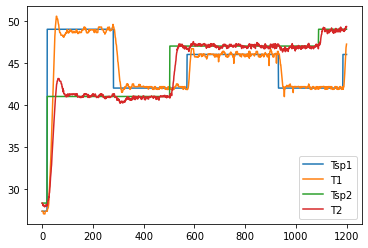

In [ ]:
data = pd.DataFrame()
# data['time'] = tm
data['Q1_lstm'] = Q1_lstm
data['T1'] = T1
data['Tsp1'] = Tsp1
data['Q1_mpc'] = Q1_mpc

data['Q2_lstm'] = Q2_lstm
data['T2'] = T2
data['Tsp2'] = Tsp2
data['Q2_mpc'] = Q2_mpc

data[['Tsp1','T1','Tsp2','T2']].plot()

Text(0.5, 1.0, 'Q1')

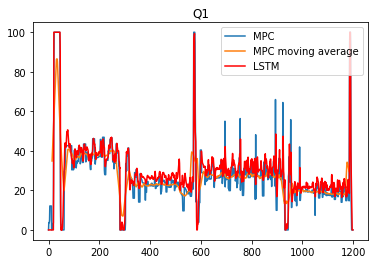

In [ ]:
# plt.plot(Q1_mpc)
# plt.plot(Q1_lstm)
plt.plot(data['Q1_mpc'],label='MPC')
plt.plot(data['Q1_mpc'].rolling(30).mean()[15:].reset_index(drop=True),label='MPC moving average')
plt.plot(data['Q1_lstm'],'r-',label='LSTM')
plt.legend()
plt.title('Q1')

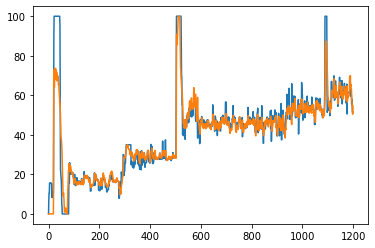

In [ ]:
plt.plot(Q2_mpc)
plt.plot(Q2_lstm)

# Run with LSTM emulator controller

In [ ]:
# Connect to Arduino
a = tclab.TCLab()
# Find current T1, T2
print('Temperature 1: {0:0.2f} °C'.format(a.T1))
print('Temperature 2: {0:0.2f} °C'.format(a.T2))

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 47.00 °C
Temperature 2: 49.26 °C


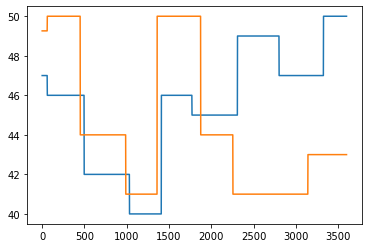

In [ ]:
# Run time in minutes
run_time = 60.0
window = 60

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature and heater data arrays
T1 = np.ones(loops) * a.T1 
Tsp1 = np.ones(loops) * a.T1 
T2 = np.ones(loops) * a.T2 
Tsp2 = np.ones(loops) * a.T2 
Q1_mpc = np.zeros(loops)
Q2_mpc = np.zeros(loops)

Q1_lstm = np.zeros(loops)
Q2_lstm = np.zeros(loops)

# Heater set point steps
end = window # leave 1st window seconds of Q1s as T.ambient
while end <= loops:
    start = end
    end += random.randint(300,600) # keep new Q1s value for anywhere from 5 to 10 minutes
    Tsp1[start:end] = random.randint(40,50)
    
end = window # leave 1st window seconds of Q1s as T.ambient
while end <= loops:
    start = end
    end += random.randint(300,600) # keep new Q1s value for anywhere from 5 to 10 minutes
    Tsp2[start:end] = random.randint(40,50)

plt.plot(Tsp1)
plt.plot(Tsp2)
# plt.ylim([0,100]);

In [ ]:
# Run TCLab with LSTM model emulating controller

for i in tqdm(range(loops)):
    # Read temperature and store it
    T1[i] = a.T1
    T2[i] = a.T2
    
    # Run LSTM model to get Q1 value for control
    if i >= window:
        # Load data for model and scale
        # Model only uses every 3 seconds of data, so need to only take every 3 data points
        T1m = T1[i-window:i][::3]/100.0
        Tspm1 = Tsp1[i-window:i][::3]/100.0
        err1 = Tspm1-T1m
        T2m = T2[i-window:i][::3]/100.0
        Tspm2 = Tsp2[i-window:i][::3]/100.0
        err2 = Tspm2-T2m
        X = np.vstack((Tspm1,err1,Tspm2,err2)).T
        X = np.reshape(X, (1, X.shape[0], X.shape[1]))
        # Predict Q for controller
        Q1c, Q2c = m_lstm.predict(X)[0] * 100.0
        # Ensure Q1c is between 0 and 100
        Q1c = np.clip(Q1c,0.0,100.0)
        Q2c = np.clip(Q2c,0.0,100.0)

        # Update TCLab heater to Q value and store Q value
        a.Q1(Q1c)
        Q1_lstm[i] = Q1c
        a.Q2(Q2c)
        Q2_lstm[i] = Q2c

#     fig = plt.figure()
#     plt.clf()
#     plt.figure(figsize=(12,4))
#     plt.subplot(121)
#     plt.plot(Tsp1,'k-',label='$SP_1$')
#     plt.plot(T1[:i],'r-',label='$T_1$')
#     plt.plot(Q1[:i],'b:',label='$Q_1$')
#     plt.legend()
#     plt.ylim((0,100))
#     plt.subplot(122)
#     plt.plot(Tsp2,'k-',label='$SP_2$')
#     plt.plot(T2[:i],'r-',label='$T_2$')
#     plt.plot(Q2[:i],'b:',label='$Q_2$')
#     plt.legend()
#     plt.ylim((0,100))
#     plt.draw
    
#     if make_mp4:
#         num = str(i)
#         num = num.zfill(len(str(loops)))
#         filename='./figures/plot_'+num+'.png'
#         plt.savefig(filename);
        
#     plt.close('all')            
    # 1 second delay 
    time.sleep(1)
    
# Turn off heaters and close
a.Q1(0)
a.Q2(0)
a.close()

100%|███████████████████████████████████████████████████| 3600/3600 [1:03:40<00:00,  1.06s/it]

TCLab disconnected successfully.


<AxesSubplot:>

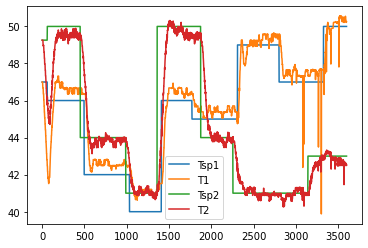

In [ ]:
data2 = pd.DataFrame()
# data['time'] = tm
data2['Q1_lstm'] = Q1_lstm
data2['T1'] = T1
data2['Tsp1'] = Tsp1
data2['Q2_lstm'] = Q2_lstm
data2['T2'] = T2
data2['Tsp2'] = Tsp2

data2[['Tsp1','T1','Tsp2','T2']].plot()